# 1. Import Dependencies and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [2]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteTVE3YT/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteTVE3YT/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [5]:
dataiterator = ds.as_numpy_iterator()

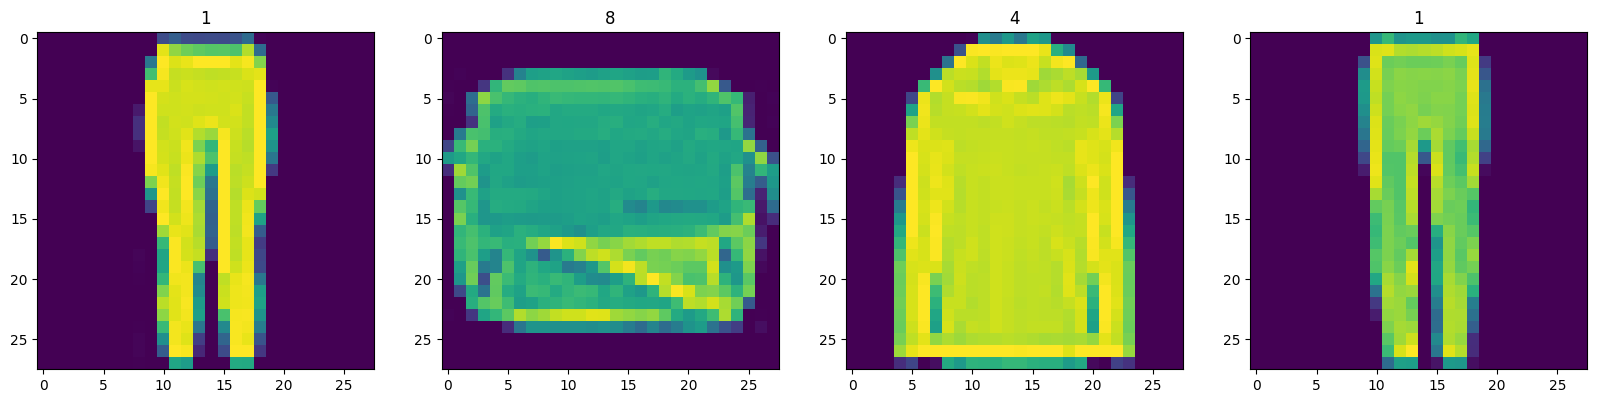

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [8]:
def scale_images(data):
    image = data['image']
    return image / 255

In [9]:
ds = tfds.load('fashion_mnist', split='train')

ds = ds.map(scale_images)

ds = ds.cache()

ds = ds.shuffle(60000)

ds = ds.batch(128)

ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [12]:
def build_generator():
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [13]:
generator = build_generator()

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [24]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 33ms/step


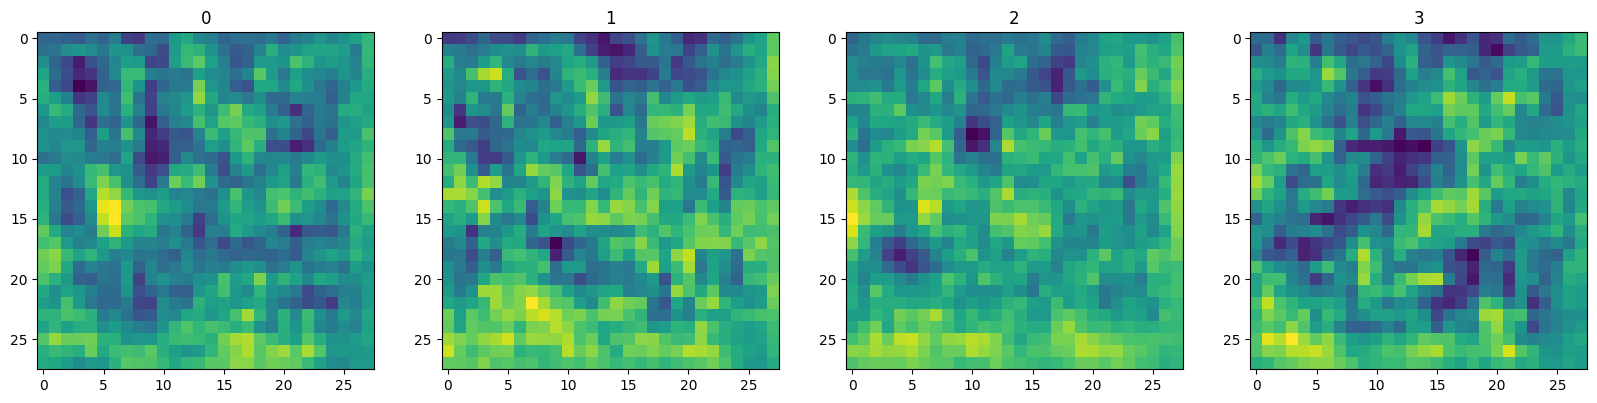

In [16]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [17]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [18]:
discriminator = build_discriminator()

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [22]:
img = img[0]

In [25]:
img.shape

(4, 28, 28, 1)

In [26]:
discriminator.predict(img)

1/1 [==============================] - 0s 252ms/step


array([[0.49064335],
       [0.49070215],
       [0.4906374 ],
       [0.4912456 ]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [28]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [29]:
from tensorflow.keras.models import Model

In [30]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [31]:
fashgan = FashionGAN(generator, discriminator)

In [32]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [33]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [35]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train

In [36]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 89s 165ms/step - d_loss: 0.5233 - g_loss: 0.9834
Epoch 2/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.4855 - g_loss: 4.6277
Epoch 3/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6920 - g_loss: 0.6952
Epoch 4/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6853 - g_loss: 0.6666
Epoch 5/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6827 - g_loss: 0.6049
Epoch 6/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6844 - g_loss: 0.5997
Epoch 7/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6951 - g_loss: 0.5892
Epoch 8/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6915 - g_loss: 0.6210
Epoch 9/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6835 - g_loss: 0.6356
Epoch 10/20
469/469 [==============================] - 76s 162ms/step - d

### 4.4 Review Performance

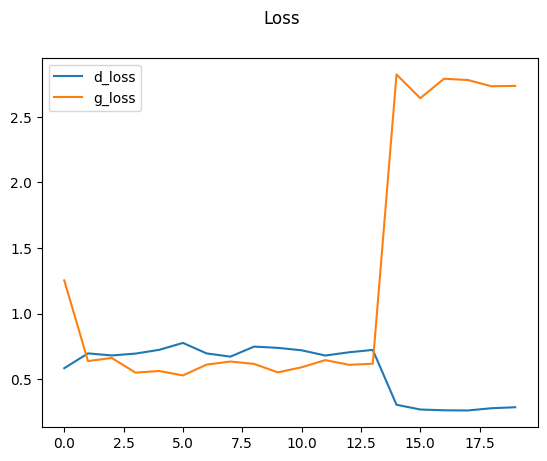

In [37]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [41]:
generator.load_weights(os.path.join('/content/generator.h5'))

In [42]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 367ms/step


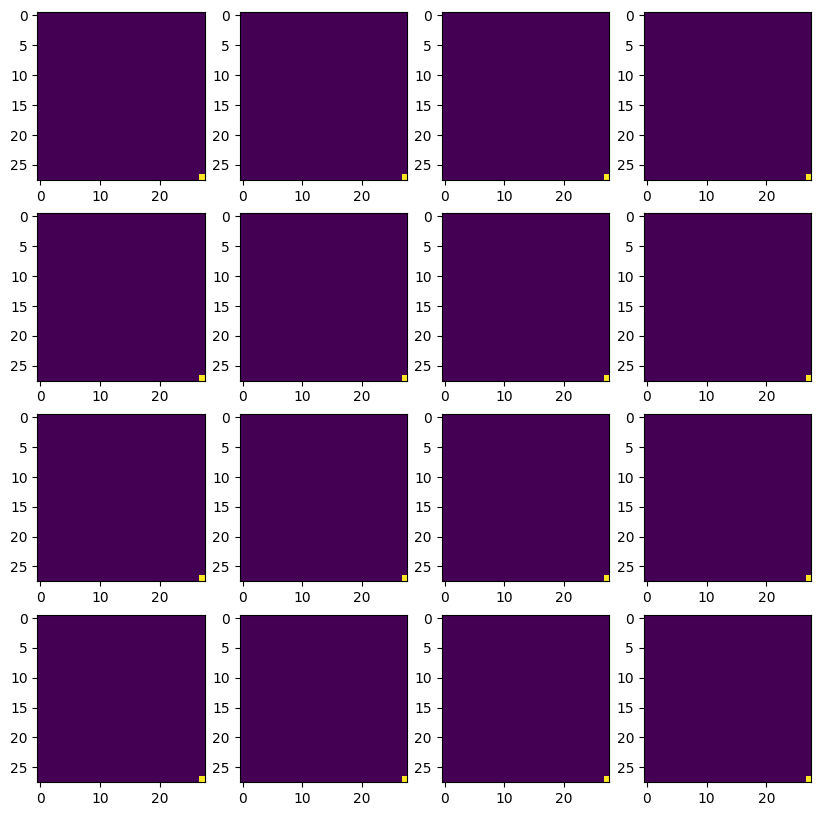

In [44]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [39]:
generator.save('/content/generator.h5')
discriminator.save('/content/discriminator.h5')